In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.ML.Cluster import Butina
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE, MDS
import matplotlib.pyplot as plt
import numpy as np

# Butina clustering

In [2]:
def butina_clustering(smile, cutoff=0.7):  
    """
    Input: a list containing smiles.
    Output: Butina cluster for the molecules, visualised with colours in a 2D plot and 
    a list with the smiles of each cluster.
    Butina clustering: Butina clustering algorithm from RDKit is used on the fingerprint vectors.
    The Tanimoto score is used for the clustering. The function returns the list: smile_cluster, 
    that contains lists with all the smiles in each of the clusters. To achive a good clustering, 
    parameter cutoff can be changed to fit the dataset.
    Butina parameters:
    cutoff: The cluster centroid is at least this similar to all other cluster members. 
    """

    # Calculates fingerprints for all smiles.
    smiles_fps = {}
    for molecule in smile:
        try:
            mol = Chem.MolFromSmiles(molecule)
            smiles_fps[molecule] = MACCSkeys.GenMACCSKeys(mol)
        except: 
            print(f"The fingerprint for {molecule} could not be generated.")
            
    # Makes 2 lists, one with all fingerprints and one with all smiles.        
    fps_ = []
    for value in smiles_fps.values():
        fps_.append(value)
        
    # Creates one vector with the bits in the fingerprint and one list with the corresponding smiles.
    bit_list = [] 
    smile_list = []
    for key, value in smiles_fps.items():
        bits = []
        bit_fp = value.ToBitString()
        for bit in bit_fp:
            bits.append(int(bit)) 
        bit_list.append(bits)
        smile_list.append(key)

    #Butina cluster: Generate the distance matrix (metric=tanimoto):
    dists = []
    len_fps = len(smile_list) 
    for fp in range(1, len_fps):
        similarities = DataStructs.BulkTanimotoSimilarity(fps_[fp], fps_[: fp])
        dists.extend([1-x for x in similarities])
        
    #Cluster the data:
    cluster = Butina.ClusterData(dists, len_fps, cutoff, isDistData=True)
    #print(f"Clusters: {cluster} \nEach tuple represent a cluster, the numbers represent the index in smile_list.")
       
    #Generates smile_cluster: a list with lists of all the smiles in one cluster and the cluster labels.
    counter = 0
    smile_cluster = []
    cluster_label = ['#']*len_fps
    for molecule in cluster:
        clusters = []
        for numb in molecule:
            cluster_label[numb] = counter
            clusters.append(smile_list[numb])
        counter += 1
        smile_cluster.append(clusters)

    return(smile_cluster, cluster_label, bit_list, smile_list)  


# DBSCAN clustering

In [3]:
def dbscan_clustering(smile, eps=0.3, min_samples=2):
    """
    Input: a list containing smiles.
    Output: DBSCAN cluster for the molecules, and a list with the smiles of each cluster.
    DBSCAN clustering: DBSCAN clustering algorithm from scikit learn is used on the 
    fingerprint vectors, with Jaccard as the pairwise distance metric. 
    The different clusters are visualised with different colours in the plot. 
    The function returns a list,called smile_cluster, containing lists with all the smiles in each cluster.
    To achive a good clustering parameters eps and min_sample can be changed to fit the dataset.
    Input to DBSCAN: 
    eps: The maximum distance between two points for them to be considered to belong in the same neighborhood.
    min_sample: The number of samples in a neighborhood for a point to be considered as a core point (including the point itself).
    """
    
    # Calculates fingerprints for all smiles.
    smiles_fps = {}
    for molecule in smile:
        try:
            mol = Chem.MolFromSmiles(molecule)
            smiles_fps[molecule] = MACCSkeys.GenMACCSKeys(mol)
        except: 
            print(f"The fingerprint for {molecule} could not be generated.")
        
    # Creates one vector (list) with all the bits in a fingerprint and one list with all the corresponding smiles.
    bit_list = [] 
    smile_list = []
    for key, value in smiles_fps.items():
        bits = []
        bit_fp = value.ToBitString()
        for bit in bit_fp:
            bits.append(int(bit))  
        bit_list.append(bits)
        smile_list.append(key)

    #DBSCAN, another clustering algoritm on the same data.
    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='jaccard').fit(np.array(bit_list))
    print(f"The clustering labels are: {clustering.labels_}. \nThe index of this list corresponds to the index of smile_list.")
    
    #Generates a list that contains lists with all smiles that are in a cluster.
    smile_cluster = []
    for number in set(clustering.labels_):
        index = 0
        lista = []
        for label in clustering.labels_:
            if label == number:
                lista.append(smile_list[index])
            index += 1
        smile_cluster.append(lista)     
    
    return smile_cluster, clustering.labels_, bit_list, smile_list


# PCA

In [4]:
def pca(fp_bit_list, clustering_labels, n_components=2):
    """
    PCA on fingerprint data down to n_components dimensions.
    clustering_labels colours the clusters according to their clusters.
    input: list with Fingerprint as bit vectors.
    output: a scatterplot of transformed data, coloured according to cluster_labels.
    """

    data = np.array(fp_bit_list)   
    pca = PCA(n_components=n_components).fit_transform(data)

    pca_plot = plt.scatter(pca[:, 0], pca[:, 1], c=clustering_labels, cmap='rainbow')
    
    return pca_plot


# tSNE

In [5]:
def tsne(fp_bit_list, clustering_labels, n_components=2, perplexity = 10.0, learning_rate = 500.0, n_iter=5000):
    """
    tsne on fingerprint data down to n_components dimensions.
    clustering_labels colours the clusters according to their clusters.
    input: list with Fingerprint as bit vectors.
    output: a scatterplot of transformed data, coloured according to cluster_labels.
    """
    data = np.array(fp_bit_list)
    tsne = TSNE(n_components = 2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter).fit_transform(data)
    tsne_plot = plt.scatter(tsne[:, 0], tsne[:, 1], c=clustering_labels, cmap='rainbow')
    
    return tsne_plot

# MDS

In [6]:
from sklearn.datasets import load_digits
from sklearn.manifold import MDS  
    
def mds(fp_bit_list, clustering_labels, n_components=2 ):
    """
    mds from fingerprint data down to n_components dimensions.
    clustering_labels colours the clusters according to their clusters.
    input: a list with Fingerprint as bit vectors.
    output: a scatterplot of transformed data, coloured according to cluster_labels.
    """
    data = fp_bit_list
    embedding = MDS(n_components=2, metric='Jaccard')
    mds_data= embedding.fit_transform(data)


    mds_plot = plt.scatter(mds_data[:, 0], mds_data[:, 1], c=clustering_labels, cmap='rainbow')
    
    return mds_plot
    

In [7]:
# De fem sista är random substrat, resten är från samma EC klass
smile = ['C[C@H](O)C([O-])=O',
 'CCCCC(O)C([O-])=O',
 'CCCCCCC(O)C([O-])=O',
 'CCCCCCC(O)C([O-])=O',
 'CCCCCCCCCCCCCCC(O)C([O-])=O',
 'CC(O)C(O)=O',
 'CSCCC(N)C(O)=O',
 'C[C@H](N)C(O)=O',
 'CC[C@H](C)[C@H](N)C(O)=O',
 'C[C@H](O)C([O-])=O',
 'CC(C)C[C@H](N)C(O)=O',
 'NCCCC[C@H](N)C(O)=O',
 'CSCC[C@H](N)C(O)=O',
 'N[C@@H](Cc1ccccc1)C(O)=O',
 'N[C@@H](Cc1c[nH]c2ccccc12)C(O)=O',
 'N[C@@H](Cc1ccc(O)cc1)C(O)=O',
 'CC(C)[C@H](N)C(O)=O',
 'OCC([O-])=O',
 '[O-]C(=O)C=O',
 'N[C@@H](CCO)C(O)=O',
 'CC(O)C([O-])=O',
 'CC(C)=CC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)CO[P](O)(=O)O[P](O)(=O)OC[C@H]1O[C@H]([C@H](O)[C@@H]1O[P](O)(O)=O)n2cnc3c(N)ncnc23',
 '[Na].CC1(C)SC2C(NC(=O)Cc3ccccc3)C(=O)N2C1C(O)=O',
 'CCCC',
 'CC(C)=CCC/C(C)=C/CC\\C(C)=C\\CC\\C(C)=C\\CC\\C(C)=C\\CC\\C(C)=C\\CC\\C(C)=C\\CC\\C(C)=C\\CC\\C(C)=C\\CC\\C(C)=C\\CC\\C(C)=C\\CO[P](O)(=O)O[P](O)(O)=O',
 '[K+].OC[C@H]1O[C@@H](SC(/CC=C)=N/O[S]([O-])(=O)=O)[C@H](O)[C@@H](O)[C@@H]1O']

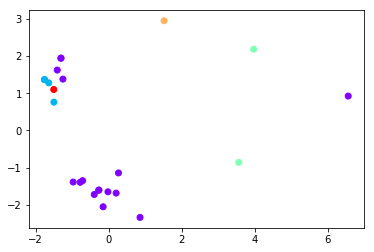

In [8]:
pca(fp_bit_list=butina_clustering(smile)[2],clustering_labels=butina_clustering(smile)[1],)

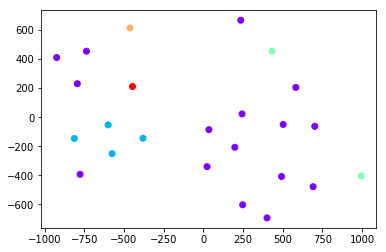

In [9]:
tsne(fp_bit_list=butina_clustering(smile)[2],clustering_labels=butina_clustering(smile)[1],)

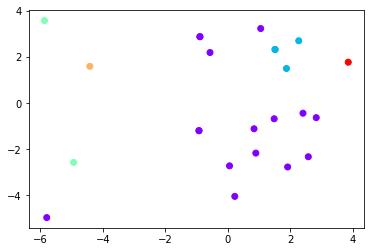

In [10]:
mds(fp_bit_list=butina_clustering(smile)[2],clustering_labels=butina_clustering(smile)[1],)

The clustering labels are: [ 0  1  1  1  0  2  3  3  3  4  2  3 -1  3  3 -1 -1  4  0 -1 -1 -1 -1 -1]. 
The index of this list corresponds to the index of smile_list.
The clustering labels are: [ 0  1  1  1  0  2  3  3  3  4  2  3 -1  3  3 -1 -1  4  0 -1 -1 -1 -1 -1]. 
The index of this list corresponds to the index of smile_list.


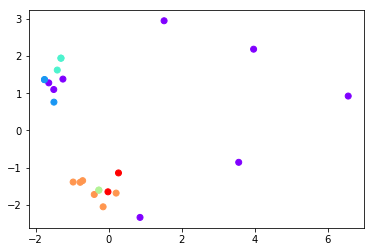

In [11]:
pca(fp_bit_list=dbscan_clustering(smile)[2],clustering_labels=dbscan_clustering(smile)[1],)

The clustering labels are: [ 0  1  1  1  0  2  3  3  3  4  2  3 -1  3  3 -1 -1  4  0 -1 -1 -1 -1 -1]. 
The index of this list corresponds to the index of smile_list.
The clustering labels are: [ 0  1  1  1  0  2  3  3  3  4  2  3 -1  3  3 -1 -1  4  0 -1 -1 -1 -1 -1]. 
The index of this list corresponds to the index of smile_list.


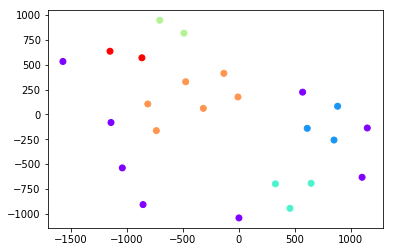

In [12]:
tsne(fp_bit_list=dbscan_clustering(smile)[2],clustering_labels=dbscan_clustering(smile)[1],)

The clustering labels are: [ 0  1  1  1  0  2  3  3  3  4  2  3 -1  3  3 -1 -1  4  0 -1 -1 -1 -1 -1]. 
The index of this list corresponds to the index of smile_list.
The clustering labels are: [ 0  1  1  1  0  2  3  3  3  4  2  3 -1  3  3 -1 -1  4  0 -1 -1 -1 -1 -1]. 
The index of this list corresponds to the index of smile_list.


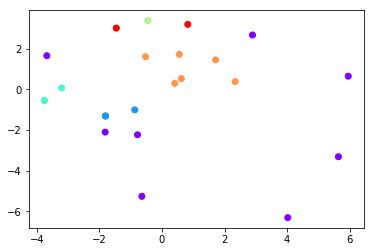

In [13]:
mds(fp_bit_list=dbscan_clustering(smile)[2],clustering_labels=dbscan_clustering(smile)[1],)